# Outlook #

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [1]:
if get_ipython().__class__.__module__ == "google.colab._shell":
    !apt-get install ffmpeg

In [2]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/osigaud/my_gym to /tmp/pip-req-build-mllp4b4x
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/my_gym /tmp/pip-req-build-mllp4b4x
^C
ERROR: Operation cancelled by user


In [ ]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from my_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [ ]:
# Agents and MDPs #




A reinforcement learning agent interacts with an environment represented as a Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$ where $S$ is the state space, $A$ is the action space, $P(state_t, action_t, state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward function and $\gamma \in [0, 1]$ is the discount factor.



In what follows we import code to create an MDP corresponding to a random maze (see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [ ]:
import gym
import my_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")

Output()

# Dynamic programming #


The goal of an RL agent is to find the optimal behaviour, defined by a policy $\pi$ that assigns an action (or distribution over actions) to each state so as to maximize the agent's total expected reward. In order to estimate how good a state is, either a state value function $V(x)$ or a state-action value function $Q(x,u)$ is used.

Dynamic programming algorithms are used for planning, they require a full knowledge of the MDP from the agent (in contrast to "true" RL where the agent does not know the transition and reward functions).
They find the optimal policy by computing a value function $V$ or an action-value function $Q$ over the state space or state-action space of the given MDP. **Value iteration** and **policy iteration** are two standard dynamic programming algorithms. You should study both of them using both $V$ and $Q$, as these algorithms contain the basic building blocks for most RL algorithms.


## Value Iteration ##

### Value Iteration with the V function ###



When using the $V$ function, **value iteration** aims at finding the optimal values $V^*$ based on the Bellman Optimality Equation:
$$V^*(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$

where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action $a$ in state $s$, 
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance of long term rewards over short term ones (the closer to 0, the more the agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the values of all states are 0), and then we iterate for all states $s$

$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y) \big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first define the `get_policy_from_V()` function

In [ ]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x not in mdp.terminal_states:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy


The `value_iteration_v(mdp)` function below provides the code of **value iteration** using the $V$ function. It is given as an example from which you can derive other instances of dynamic programming algorithms. Look at it more closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these updates until the values don't change significantly anymore, the main update equation. Found them? OK, you can continue...


In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def value_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    video_recorder = VideoRecorder(mdp, "videos/ValueIterationV.mp4", enabled=render)
    mdp.set_title("Value iteration V")
    if render:
        mdp.render()
        video_recorder.capture_frame()
    mdp.set_render_func(mdp.draw_v, lambda draw: draw(v))

    while not stop:
        v_old = v.copy()
        if render:
            mdp.render()
            video_recorder.capture_frame()

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x not in mdp.terminal_states:
                v_temp = []
                for u in mdp.action_space.actions:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        policy = get_policy_from_v(mdp, v)
        mdp.set_render_func(mdp.draw_v_pi, lambda draw: draw(v, policy))
        mdp.render()
        video_recorder.capture_frame()


    video_recorder.close()
    return v, v_list

Let us run it on the previously defined MDP

In [ ]:
v, v_list = value_iteration_v(env, render=True)

Output()

In [ ]:
display(Video(filename="./videos/ValueIterationV.mp4"))

### Value iteration with the $Q$ function ###


The state-action value function $Q^{\pi}(s,a)$ defines the value of being in state $s$, taking action $a$ then following policy $\pi$. The Bellman Optimality Equation for $Q^*$ is
$$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y} P(s,a,y) \max_{a'}Q^*(y,a'). $$ 


**Question:** By taking inspiration from the `value_iteration_v(mdp)` function above, fill the blank (given with '\#Q[x,u]=...') in the code of `value_iteration_q(mdp)`.

In [ ]:
print(env)

<TimeLimit<MazeMDPEnv<MazeMDP-v0>>>


In [ ]:

# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


def value_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    stop = False

    

    if render:
        mdp.init_draw("Value iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Value iteration Q")

        for x in range(mdp.nb_states):
            if x not in mdp.terminal_states:
                for u in mdp.action_space.actions:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])
                        
                    q[x,u]= mdp.r[x, u] + mdp.gamma * summ
                    

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    if render:
        mdp.draw_v(q, title="Value iteration Q")
        mdp.mdp.plotter.video_writer.release()

    return q, q_list


Once you are done, run it.

In [ ]:
q, q_list = value_iteration_q(env, render=True)

Output()

In [ ]:
show_videos("videos/", prefix="ValueiterationQ")

Converting videos/ValueiterationQ.avi


ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

## Policy Iteration ##


The **policy iteration** algorithm is more complicated than **value iteration**.
Given a MDP and a policy $\pi$, **policy iteration** iterates the following steps: 

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be improved anymore.


### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state $s$ and following policy $\pi$. It is processed based on the Bellman Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$


where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.


Thus, given a policy $\pi$, one must first compute its value function $V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until convergence, that is using **value iteration**.
Then, one must determine if policy $\pi$ can be improved based on $V$. For that, in each state $s$, one can compute the Q-value $Q(s,a)$ of applying action $a$ and then following policy $\pi$ based on the just computed $V^\pi$, and replace the action $\pi(s)$ with $\arg\max_a Q(s,a)$.



In order to facilitate the coding of **policy iteration** algorithms, we first define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the `get_policy_from_v(v)` function which was given above. The main difference is that it takes a policy as argument and improves this policy when possible, thus is is more in the spirit of the `policy improvement` step of **policy iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given MDP, `v` is some value function in this MDP and `policy` is some policy and the function `evaluate_v(mdp, policy)` are also given. These functions are used to build the value function $V^\pi$ corresponding to policy $\pi$.


In [ ]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            v_temp = np.zeros(mdp.action_space.size)
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in mdp.action_space.actions:
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [ ]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
    return v_new
𝑉𝜋(𝑦),

In [ ]:
def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    while not stop:
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v


To perform **policy iteration** we also need an initial random policy.

In [ ]:
from mazemdp import random_policy

**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [ ]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.init_draw("Policy iteration V")

    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v = evaluate_v(mdp, policy)

        if render:
            mdp.draw_v_pi(v, policy, title="Policy iteration V")

        # Step 2 : Policy Improvement
        # À compléter...  
        policy = improve_policy_from_v(mdp, v, policy)
        
        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()

    return v, v_list


And finally run it.

In [ ]:
v, v_list = policy_iteration_v(env, render=True)

Output()

In [ ]:
show_videos("videos/", prefix="PolicyiterationV")

Converting videos/PolicyiterationV.avi


ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

### Policy iteration with the $Q$ function ###


The **policy iteration** algorithm with the $Q$ function is the same as with the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy $\pi$ for $Q$ becomes: 
$$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
$$\pi^{(t+1)}(s) = \arg\max_aQ^{\pi^{(t)}}(s,a).$$


First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the state-action value function.

In [ ]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # À compléter...
    policy = np.zeros(len(q), dtype = np.int64)
    for i, x in enumerate(q):
        policy[i] = np.argmax(x)
    return policy


**Question:** By drawing inspiration on the functions give with the $v$ function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function below, where $q$ is some action value function, and the `evaluate_q(mdp, policy)` function.

In [ ]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
    return qnew

In [ ]:
def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    steps = 0
    while not stop:
        qold = q.copy()
        steps += 1
        q = evaluate_one_step_q(mdp, q, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    print("steps", steps )
    return q

**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [ ]:
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q = evaluate_q(mdp, policy)

        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list


Finally, run it.

In [ ]:
q, q_list = policy_iteration_q(env, render=True)

Output()

steps 3
steps 5
steps 6
steps 6
steps 7
steps 8
steps 9
steps 11
steps 11


In [ ]:
print(q_list)

[2.193171219946131, 2.9839678282448023, 3.8571311670722324, 4.280326917421146, 4.7439793213293, 5.088663305719097, 5.35160810724845, 5.542788470241021, 5.542788470241021]


In [ ]:
show_videos("videos/", prefix="PolicyiterationQ")

Converting videos/PolicyiterationQ.avi


ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.


In [ ]:

# ---- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax -----#

def plot_convergence_vi_pi(m, render):
    v, v_list1 = value_iteration_v(m, render)
    q, q_list1 = value_iteration_q(m, render)
    v, v_list2 = policy_iteration_v(m, render)
    q, q_list2 = policy_iteration_q(m, render)

    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='upper right')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

**Question:** Run the code below and visualize the results of the different algorithms

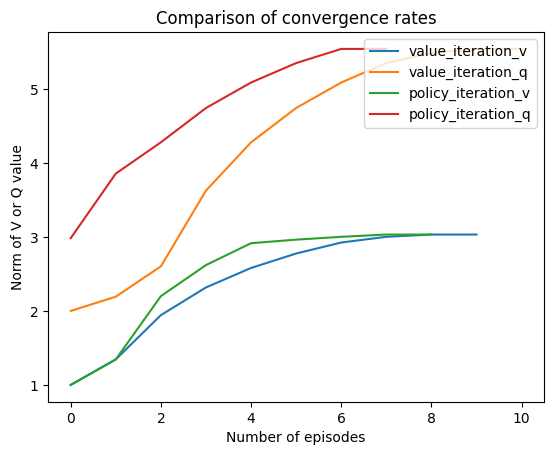

In [ ]:
plot_convergence_vi_pi(env, False)


In [ ]:
# Completer temps de calcul et jouer avec dimension et different tailles

dimensions =

env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")


Given the results above, discuss the relative computational efficiency of these methods.

### Study part: Generalized Policy Iteration

Code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step

In [ ]:
def evaluate_q_k(mdp: MazeMDPEnv, policy: np.ndarray, k: int64) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()
        
        q = evaluate_one_step_q(mdp, q, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q

# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def generalized_policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q = evaluate_q(mdp, policy)

        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list
